In [1]:
import torch
import esm

# Load the model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()

# Encode a sequence
sequence = "QNGQNVSVANAGWNTVIPAGGTVSFGFQGSYSGANAVPGTFKLNGTTTSPP"
token_ids = torch.tensor([alphabet.encode(sequence)])

# Extract features
with torch.no_grad():
    results = model(token_ids, repr_layers=[33])  # Assuming you are using the last layer
features = results["representations"][33]

# Optionally, average over all positions to get a single vector for the sequence
sequence_feature = features.mean(dim=1)  # Average pooling over positions

In [2]:
print(sequence_feature)

tensor([[ 0.0495,  0.1033, -0.1275,  ...,  0.1056, -0.0707,  0.2026]])


In [3]:
len(sequence_feature)

1

In [5]:
sequence_feature.size()

torch.Size([1, 1280])

In [1]:
import os
import torch
from Bio.PDB import PDBParser, Polypeptide
import esm

# 定义数据目录
data_dir = 'E:/iGEM/前期准备/GCN/data/24.4.18 pdb_3D_dataset'
subdirs = ['label_0', 'label_1', 'label_2']

# 加载 ESM 模型
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()

# PDB 文件解析器
parser = PDBParser(QUIET=True)

# 提取特征函数
def extract_esm_features(sequence):
    token_ids = torch.tensor([alphabet.encode(sequence)])
    with torch.no_grad():
        results = model(token_ids, repr_layers=[33])
    features = results['representations'][33]
    return features.mean(dim=1)

# 提取 PDB 文件的序列
def extract_sequences_from_pdb(pdb_file):
    structure = parser.get_structure('protein', pdb_file)
    sequences = {}
    for model in structure:
        for chain in model:
            ppb = Polypeptide.PPBuilder()
            chain_seq = "".join([str(pp.get_sequence()) for pp in ppb.build_peptides(chain)])
            sequences[chain.id] = chain_seq
    return sequences

# 遍历文件夹并处理每个 PDB 文件
all_features = {}

for subdir in subdirs:
    subdir_path = os.path.join(data_dir, subdir)
    pdb_files = [f for f in os.listdir(subdir_path) if f.endswith('.pdb')]

    for pdb_file in pdb_files:
        pdb_path = os.path.join(subdir_path, pdb_file)
        sequences = extract_sequences_from_pdb(pdb_path)

        for chain_id, sequence in sequences.items():
            # 提取 ESM 特征
            features = extract_esm_features(sequence)
            key = f"{subdir}/{pdb_file}_{chain_id}"
            all_features[key] = features

# 打印或保存提取的特征
for key, feature in all_features.items():
    print(f"{key}: {feature}")


label_0/label0_1.pdb_A: tensor([[ 0.0495,  0.1033, -0.1275,  ...,  0.1056, -0.0707,  0.2026]])
label_0/label0_10.pdb_A: tensor([[ 0.0913,  0.1677, -0.0369,  ..., -0.0152,  0.1351,  0.1758]])
label_0/label0_11.pdb_A: tensor([[ 0.0072, -0.0317,  0.0952,  ...,  0.0100,  0.0037,  0.1848]])
label_0/label0_12.pdb_A: tensor([[ 0.1956,  0.0458,  0.0863,  ..., -0.0335,  0.0896,  0.1447]])
label_0/label0_13.pdb_A: tensor([[-0.0164,  0.1004, -0.0674,  ...,  0.1062,  0.0111,  0.1061]])
label_0/label0_14.pdb_A: tensor([[ 0.0762, -0.0014, -0.1658,  ...,  0.0143,  0.1025,  0.1602]])
label_0/label0_15.pdb_A: tensor([[ 0.1700,  0.0987,  0.0685,  ..., -0.2074,  0.1383,  0.1284]])
label_0/label0_16.pdb_A: tensor([[-0.0510,  0.1337, -0.0085,  ...,  0.0610, -0.0762,  0.1816]])
label_0/label0_17.pdb_A: tensor([[ 0.0008,  0.1333, -0.0559,  ...,  0.0330,  0.0213,  0.2076]])
label_0/label0_18.pdb_A: tensor([[ 0.1060,  0.1239, -0.0622,  ..., -0.0057,  0.0934,  0.1731]])
label_0/label0_19.pdb_A: tensor([[ 0.1292

75x1280

In [7]:
import numpy as np
import torch
from torch_geometric.data import Data
import esm

# 预加载 ESM 模型
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()

# 读取 PDB 文件并提取 ESM 特征
def parse_pdb_and_get_esm_features(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    coords = []
    sequences = []
    current_residue_index = None
    chain_sequence = []
    residue_indices = []

    for line in lines:
        if line.startswith('ATOM') and line[13:15].strip() == 'CA':  # 仅考虑α碳
            x = float(line[30:38].strip())
            y = float(line[38:46].strip())
            z = float(line[46:54].strip())
            residue_index = int(line[22:26].strip())
            residue_type = line[17:20].strip()

            if residue_index != current_residue_index:
                coords.append((x, y, z))
                residue_indices.append(residue_index)
                chain_sequence.append(residue_type)
                current_residue_index = residue_index

    # 将氨基酸3字母代码转换为1字母代码
    aa_mapping = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
        'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
        'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    sequence = ''.join([aa_mapping.get(res, 'X') for res in chain_sequence])  # 默认用'X'表示未知残基类型

    # 使用 ESM 模型提取特征
    token_ids = torch.tensor([alphabet.encode(sequence)])
    with torch.no_grad():
        results = model(token_ids, repr_layers=[33])
    features = results['representations'][33].squeeze(0)

    return coords, features, residue_indices

# 构建图结构
def build_graph_from_esm_features(filepath, threshold=6.0):
    coords, node_features, residue_indices = parse_pdb_and_get_esm_features(filepath)
    num_residues = len(residue_indices)

    # 构建边关系
    edges = []
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            if np.linalg.norm(np.array(coords[i]) - np.array(coords[j])) < threshold:
                edges.append([i, j])
                edges.append([j, i])  # 无向图

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    label = torch.tensor([0])  # 假设一个固定标签

    # 创建Data对象
    data = Data(x=node_features, edge_index=edge_index, y=label)
    return data

# 示例用法
filepath = 'E:/iGEM/前期准备/pythonProject/data/24.4.18 pdb_3D_dataset'  # 使用实际的 PDB 文件路径
graph_data = build_graph_from_esm_features(filepath)

# 打印或进一步处理 `graph_data` 对象
print(graph_data)


PermissionError: [Errno 13] Permission denied: 'E:/iGEM/前期准备/pythonProject/data/24.4.18 pdb_3D_dataset'

In [8]:
import os
import torch
import numpy as np
from torch_geometric.data import Data
import esm

# 加载预训练的 ESM 模型
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()

# 从 PDB 文件中提取 ESM 特征的函数
def parse_pdb_and_get_esm_features(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    coords = []
    sequences = []
    current_residue_index = None
    chain_sequence = []
    residue_indices = []

    for line in lines:
        if line.startswith('ATOM') and line[13:15].strip() == 'CA':  # 仅考虑 α 碳
            x = float(line[30:38].strip())
            y = float(line[38:46].strip())
            z = float(line[46:54].strip())
            residue_index = int(line[22:26].strip())
            residue_type = line[17:20].strip()

            if residue_index != current_residue_index:
                coords.append((x, y, z))
                residue_indices.append(residue_index)
                chain_sequence.append(residue_type)
                current_residue_index = residue_index

    # 将氨基酸3字母代码转换为1字母代码
    aa_mapping = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
        'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
        'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    sequence = ''.join([aa_mapping.get(res, 'X') for res in chain_sequence])  # 默认用'X'表示未知残基类型

    # 使用 ESM 模型提取特征
    token_ids = torch.tensor([alphabet.encode(sequence)])
    with torch.no_grad():
        results = model(token_ids, repr_layers=[33])
    features = results['representations'][33].squeeze(0)

    return coords, features, residue_indices

# 基于 ESM 特征构建图结构
def build_graph_from_esm_features(filepath, threshold=6.0):
    coords, node_features, residue_indices = parse_pdb_and_get_esm_features(filepath)
    num_residues = len(residue_indices)

    # 构建边关系
    edges = []
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            if np.linalg.norm(np.array(coords[i]) - np.array(coords[j])) < threshold:
                edges.append([i, j])
                edges.append([j, i])  # 无向图

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    label = torch.tensor([0])  # 假设一个固定标签

    # 创建 Data 对象
    data = Data(x=node_features, edge_index=edge_index, y=label)
    return data

# 遍历所有文件夹并处理其中的每个 PDB 文件
root_dir = 'E:/iGEM/前期准备/GCN/data/24.4.18 pdb_3D_dataset'
subdirs = ['label_0', 'label_1', 'label_2']

for subdir in subdirs:
    subdir_path = os.path.join(root_dir, subdir)

    # 检查子文件夹是否存在
    if not os.path.isdir(subdir_path):
        continue

    # 列出当前子文件夹中的所有 PDB 文件
    pdb_files = [f for f in os.listdir(subdir_path) if f.endswith('.pdb')]

    for pdb_file in pdb_files:
        pdb_filepath = os.path.join(subdir_path, pdb_file)

        # 调用 `build_graph_from_esm_features` 函数
        graph_data = build_graph_from_esm_features(pdb_filepath)

        # 打印或进一步处理 `graph_data` 对象
        print(graph_data)


Data(x=[51, 1280], edge_index=[2, 162], y=[1])
Data(x=[34, 1280], edge_index=[2, 140], y=[1])
Data(x=[46, 1280], edge_index=[2, 166], y=[1])
Data(x=[46, 1280], edge_index=[2, 156], y=[1])
Data(x=[52, 1280], edge_index=[2, 174], y=[1])
Data(x=[40, 1280], edge_index=[2, 124], y=[1])
Data(x=[27, 1280], edge_index=[2, 108], y=[1])
Data(x=[44, 1280], edge_index=[2, 128], y=[1])
Data(x=[67, 1280], edge_index=[2, 304], y=[1])
Data(x=[53, 1280], edge_index=[2, 232], y=[1])
Data(x=[64, 1280], edge_index=[2, 238], y=[1])
Data(x=[26, 1280], edge_index=[2, 80], y=[1])
Data(x=[62, 1280], edge_index=[2, 506], y=[1])
Data(x=[51, 1280], edge_index=[2, 162], y=[1])
Data(x=[26, 1280], edge_index=[2, 80], y=[1])
Data(x=[47, 1280], edge_index=[2, 174], y=[1])
Data(x=[47, 1280], edge_index=[2, 266], y=[1])
Data(x=[58, 1280], edge_index=[2, 202], y=[1])
Data(x=[56, 1280], edge_index=[2, 216], y=[1])
Data(x=[65, 1280], edge_index=[2, 232], y=[1])
Data(x=[44, 1280], edge_index=[2, 120], y=[1])
Data(x=[51, 128

In [1]:
import os
import torch
import numpy as np
from torch_geometric.data import Data
import esm

# 加载预训练的 ESM 模型
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model.eval()

# 从 PDB 文件中提取 ESM 特征的函数
def parse_pdb_and_get_esm_features(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    coords = []
    chain_sequence = []
    residue_indices = []
    current_residue_index = None

    for line in lines:
        if line.startswith('ATOM') and line[13:15].strip() == 'CA':  # 仅考虑 α 碳
            x = float(line[30:38].strip())
            y = float(line[38:46].strip())
            z = float(line[46:54].strip())
            residue_index = int(line[22:26].strip())
            residue_type = line[17:20].strip()

            if residue_index != current_residue_index:
                coords.append((x, y, z))
                residue_indices.append(residue_index)
                chain_sequence.append(residue_type)
                current_residue_index = residue_index

    # 将氨基酸 3 字母代码转换为 1 字母代码
    aa_mapping = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
        'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
        'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    sequence = ''.join([aa_mapping.get(res, 'X') for res in chain_sequence])  # 默认用 'X' 表示未知残基类型

    # 使用 ESM 模型提取特征
    token_ids = torch.tensor([alphabet.encode(sequence)])
    with torch.no_grad():
        results = model(token_ids, repr_layers=[33])
    features = results['representations'][33].squeeze(0)

    return coords, features, residue_indices

# 基于 ESM 特征构建图结构
def build_graph_from_esm_features(filepath, threshold=6.0):
    coords, node_features, residue_indices = parse_pdb_and_get_esm_features(filepath)
    num_residues = len(residue_indices)

    # 构建边关系
    edges = []
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            if np.linalg.norm(np.array(coords[i]) - np.array(coords[j])) < threshold:
                edges.append([i, j])
                edges.append([j, i])  # 无向图

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # 创建 Data 对象
    data = Data(x=node_features, edge_index=edge_index, y=torch.tensor([0]))  # 默认标签为 0
    return data

# 创建 graph_data_list 的函数
def create_graph_data_list(root_dir, subdirs):
    graph_data_list = []

    for subdir in subdirs:
        subdir_path = os.path.join(root_dir, subdir)

        # 检查子文件夹是否存在
        if not os.path.isdir(subdir_path):
            continue

        # 列出当前子文件夹中的所有 PDB 文件
        pdb_files = [f for f in os.listdir(subdir_path) if f.endswith('.pdb')]

        for pdb_file in pdb_files:
            pdb_filepath = os.path.join(subdir_path, pdb_file)

            # 调用 `build_graph_from_esm_features` 函数
            graph_data = build_graph_from_esm_features(pdb_filepath)

            # 根据子文件夹设置 graph_data 的 `y` 属性
            if 'label_0' in subdir:
                graph_data.y = torch.tensor([0])
            elif 'label_1' in subdir:
                graph_data.y = torch.tensor([1])
            elif 'label_2' in subdir:
                graph_data.y = torch.tensor([2])

            # 将图数据对象加入列表
            graph_data_list.append(graph_data)

    return graph_data_list

# 使用创建的函数
root_dir = 'E:/iGEM/前期准备/GCN/data/24.4.18 pdb_3D_dataset'
subdirs = ['label_0', 'label_1', 'label_2']
graph_data_list = create_graph_data_list(root_dir, subdirs)
print(graph_data_list)
print(f'Total graphs loaded: {len(graph_data_list)}')


[Data(x=[51, 1280], edge_index=[2, 162], y=[1]), Data(x=[34, 1280], edge_index=[2, 140], y=[1]), Data(x=[46, 1280], edge_index=[2, 166], y=[1]), Data(x=[46, 1280], edge_index=[2, 156], y=[1]), Data(x=[52, 1280], edge_index=[2, 174], y=[1]), Data(x=[40, 1280], edge_index=[2, 124], y=[1]), Data(x=[27, 1280], edge_index=[2, 108], y=[1]), Data(x=[44, 1280], edge_index=[2, 128], y=[1]), Data(x=[67, 1280], edge_index=[2, 304], y=[1]), Data(x=[53, 1280], edge_index=[2, 232], y=[1]), Data(x=[64, 1280], edge_index=[2, 238], y=[1]), Data(x=[26, 1280], edge_index=[2, 80], y=[1]), Data(x=[62, 1280], edge_index=[2, 506], y=[1]), Data(x=[51, 1280], edge_index=[2, 162], y=[1]), Data(x=[26, 1280], edge_index=[2, 80], y=[1]), Data(x=[47, 1280], edge_index=[2, 174], y=[1]), Data(x=[47, 1280], edge_index=[2, 266], y=[1]), Data(x=[58, 1280], edge_index=[2, 202], y=[1]), Data(x=[56, 1280], edge_index=[2, 216], y=[1]), Data(x=[65, 1280], edge_index=[2, 232], y=[1]), Data(x=[44, 1280], edge_index=[2, 120], y

ValueError: x and y must have same first dimension, but have shapes (80,) and (76,)

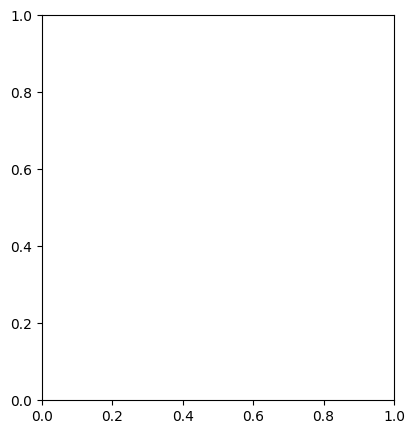

Confusion matrix, without normalization
[[4. 1. 0.]
 [1. 2. 0.]
 [0. 0. 3.]]


ValueError: Unknown format code 'd' for object of type 'float'

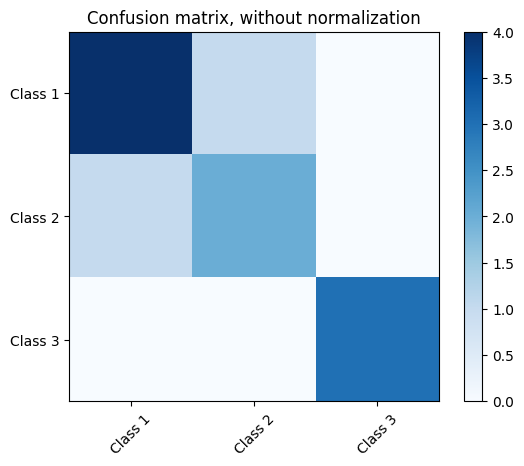

In [1]:
import torch
print(torch.cuda.is_available())

False


In [1]:
import torch
print(torch.cuda.memory_allocated())  # 返回当前分配的显存量
print(torch.cuda.memory_reserved())   # 返回当前预留的显存总量

0
0


In [5]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    # 创建一个张量并移动到 GPU 上
    x = torch.tensor([1.0, 2.0, 3.0]).cuda()
    print("Tensor on GPU:", x)

    # 检查显存使用情况
    print("Memory Allocated:", torch.cuda.memory_allocated())
    print("Memory Reserved:", torch.cuda.memory_reserved())
if torch.cuda.is_available():
    a = torch.randn(1000, 1000, device="cuda")
    b = torch.randn(1000, 1000, device="cuda")
    c = a + b  # 执行 GPU 上的计算
    print("Memory Allocated After Computation:", torch.cuda.memory_allocated())


Is CUDA available: True
CUDA Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
Tensor on GPU: tensor([1., 2., 3.], device='cuda:0')
Memory Allocated: 512
Memory Reserved: 2097152
Memory Allocated After Computation: 12001280
